In [88]:
import pandas as pd
import seaborn as sb

In [89]:
df=pd.read_csv('../../data/whisper_med_evalOLD.csv')
df.head()

,Wall time,step,cer,model,language,LoRA,lang_prompt
0,1.731813e+09,1000,0.152966,whisper-medium-tira-hr,tira,False,hr
1,1.731815e+09,2000,0.147247,whisper-medium-tira-hr,tira,False,hr
2,1.731817e+09,3000,0.121457,whisper-medium-tira-hr,tira,False,hr
3,1.731819e+09,4000,0.115885,whisper-medium-tira-hr,tira,False,hr
4,1.731821e+09,5000,0.111876,whisper-medium-tira-hr,tira,False,hr


### Add columns for LoRA & lang prompt

In [90]:
df['LoRA']=df['model'].str.contains('lora')
df['LoRA'].value_counts()

LoRA
False    240
True     160
Name: count, dtype: int64

In [91]:
lang_prompts=['yo', 'sw', 'hr', 'lang-token']
def get_lang_prompt(model):
    for lang in lang_prompts:
        if lang in model:
            if lang=='lang-token':
                return 'tira (new)'
            return lang
    return 'LID'
df['lang_prompt']=df['model'].apply(get_lang_prompt)
df

,Wall time,step,cer,model,language,LoRA,lang_prompt
0,1.731813e+09,1000,0.152966,whisper-medium-tira-hr,tira,False,hr
1,1.731815e+09,2000,0.147247,whisper-medium-tira-hr,tira,False,hr
2,1.731817e+09,3000,0.121457,whisper-medium-tira-hr,tira,False,hr
3,1.731819e+09,4000,0.115885,whisper-medium-tira-hr,tira,False,hr
4,1.731821e+09,5000,0.111876,whisper-medium-tira-hr,tira,False,hr
...,...,...,...,...,...,...,...
395,1.731618e+09,36000,0.575375,whisper-medium-tira,eng,False,LID
396,1.731621e+09,37000,0.566455,whisper-medium-tira,eng,False,LID
397,1.731623e+09,38000,0.580310,whisper-medium-tira,eng,False,LID
398,1.731625e+09,39000,0.562512,whisper-medium-tira,eng,False,LID


### Add initial CER for English for all models

In [92]:
eng_init_cer=0.07026491296896616
new_rows=[]
for model in df['model'].unique():
    new_rows.append({
        'model': model,
        'language': 'eng',
        'step': 0,
        'cer': eng_init_cer,
        'LoRA': 'lora' in model,
        'lang_prompt': get_lang_prompt(model),
    })

new_rows=pd.DataFrame(new_rows)
df_w_init_eng=pd.concat([df, new_rows])
print(df.shape, df_w_init_eng.shape)

(400, 7) (409, 7)


In [93]:
tira_init_cer_dict={
    'sw': 1.582825063841462,
    'yo': 4.111474579490535,
    'hr': 0.7216934343540933,
    'LID': 3.2431884853217396,
}
new_rows=[]
for lang_prompt, cer in tira_init_cer_dict.items():
    new_rows.append({
        'model': 'whisper-medium-tira-'+lang_prompt if lang_prompt!='LID' else 'whisper-medium-tira',
        'language': 'tira',
        'step': 0,
        'cer': cer,
        'lang_prompt': lang_prompt,
        'LoRA': False
    })
    new_rows.append({
        'model': 'whisper-medium-tira-lora-'+lang_prompt if lang_prompt!='LID' else 'whisper-medium-tira-lora',
        'language': 'tira',
        'step': 0,
        'cer': cer,
        'lang_prompt': lang_prompt,
        'LoRA': True
    })


new_rows=pd.DataFrame(new_rows)
df_w_init_tira=pd.concat([df_w_init_eng, new_rows])
print(df_w_init_eng.shape, df_w_init_tira.shape)

(409, 7) (417, 7)


In [94]:
df_w_init_tira['model'].unique()

array(['whisper-medium-tira-hr', 'whisper-medium-tira-lang-token',
       'whisper-medium-tira-lora-hr', 'whisper-medium-tira-lora-sw',
       'whisper-medium-tira-lora-yo', 'whisper-medium-tira-lora',
       'whisper-medium-tira-sw', 'whisper-medium-tira-yo',
       'whisper-medium-tira'], dtype=object)

In [95]:
df.to_csv('../../data/whisper_med_evalOLD.csv',index=False)
df_w_init_tira.to_csv('../../data/whisper_med_eval.csv',index=False)
df=pd.read_csv('../../data/whisper_med_eval.csv')

Text(0.5, 1.0, 'Whisper medium performance on Tira')

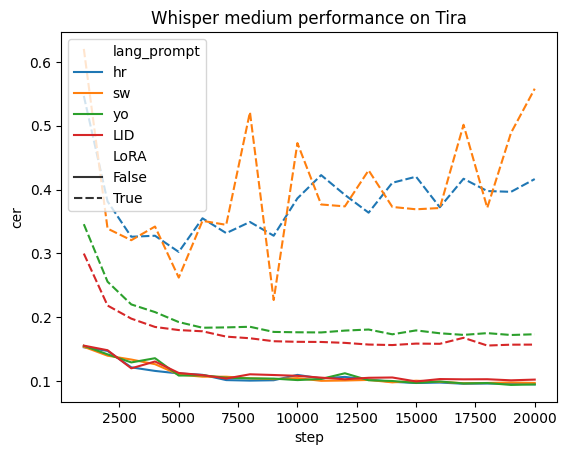

In [99]:
ax=sb.lineplot(
    df[
        (df['step']<=20_000) &
        (df['lang_prompt']!='tira (new)') &
        (df['step']>0) &
        (df['language']=='tira')
    ],
    x='step',
    y='cer',
    hue='lang_prompt',
    errorbar=None,
    style='LoRA',
)
ax.set_title('Whisper medium performance on Tira')

Text(0.5, 1.0, 'Performance on English (while training on Tira)')

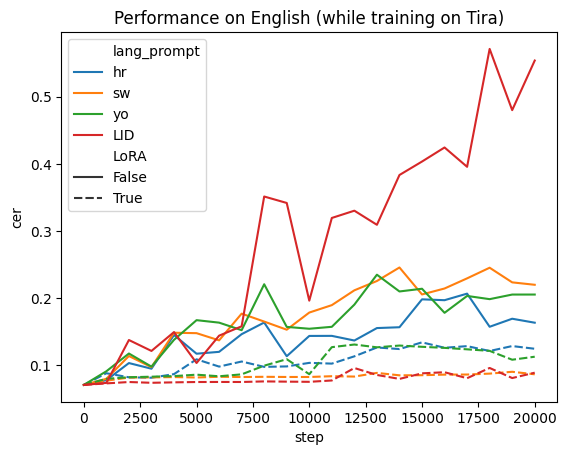

In [98]:
ax=sb.lineplot(
    df[
        (df['step']<=20_000) &
        # (df['step']>0) &
        (df['language']=='eng') &
        (df['lang_prompt']!='tira (new)')
    ],
    x='step',
    y='cer',
    hue='lang_prompt',
    errorbar=None,
    style='LoRA',
)
ax.set_title('Performance on English (while training on Tira)')

Text(0.5, 1.0, 'Performance while finetuning language prompt for Tira')

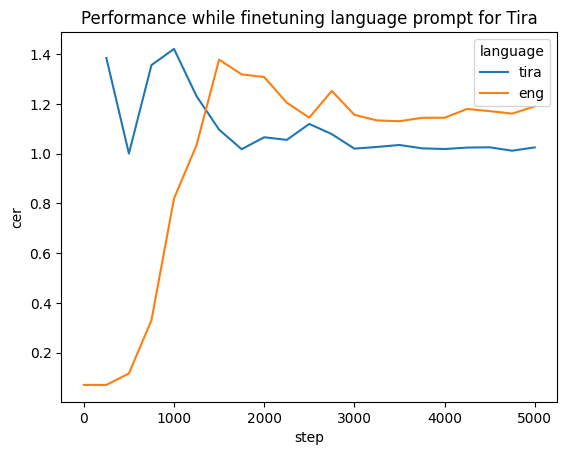

In [102]:
ax=sb.lineplot(
    df[
        (df['step']<=20_000) &
        # (df['step']>0) &
        # (df['language']=='eng') &
        (df['lang_prompt']=='tira (new)')
    ],
    x='step',
    y='cer',
    hue='language',
    errorbar=None,
    # style='LoRA',
)
ax.set_title('Performance while finetuning language prompt for Tira')